In [8]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [9]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [10]:
#torch.cuda.set_device(2)

In [11]:
torch.backends.cudnn.benchmark=True

## Data

In [12]:
PATH = Path('data/kaggle/TGS-Salt')
MASKS_FN = 'train.csv'
META_FN = 'depths.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)


TEST_DN = 'test/'
TEST_FN = 'sample_submission.csv'
test_csv = pd.read_csv(PATH/TEST_FN)

In [13]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [14]:
TRAIN_DN = 'train-101'
MASKS_DN = 'train_masks-101'
sz = 128
bs = 128
nw = 16

In [15]:
TRAIN_DN = 'train/images'
MASKS_DN = 'train/masks'
sz = 128
bs = 64
nw = 16

In [16]:
# class MatchedFilesDataset(FilesDataset):
#     def __init__(self, fnames, y, transform, path):
#         self.y=y
#         assert(len(fnames)==len(y))
#         super().__init__(fnames, transform, path)
#     def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
#     def get_c(self): return 0

In [43]:
meta_csv.head()

id    z
0  4ac19fb269  306
1  1825fadf99  157
2  f59821d067  305
3  5b435fad9d  503
4  e340e7bfca  783

In [33]:
def get_multi_y(y, y_sz = None):
    y = open_image(y)
    multi_y = np.dstack([(y == 30)*1, # back
    (y == 110)*1, # fore
    (y == 215)*1]).transpose(2,0,1) # bound
    if y_sz is not None:
        multi_y = np.array([cv2.resize(y.astype(np.uint8), (y_sz, y_sz)) for y in multi_y])
    return multi_y.astype(np.float32)

class NucleiDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path, y_sz=sz):
        self.y_sz = y_sz
        self.y=y
        super().__init__(fnames, transform, path)
    def get_y(self, i): return get_multi_y(os.path.join(self.path, self.y[i]), self.y_sz)
    def get_c(self): return 0

In [34]:
x_names = np.array([Path(TRAIN_DN)/f'{o}.png' for o in masks_csv['id']])
y_names = np.array([Path(MASKS_DN)/f'{o}.png' for o in masks_csv['id']])

In [35]:
val_idxs = list(range(10))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [36]:
x_test = np.array([Path(TEST_DN)/f'{o}.png' for o in test_csv['id']])
y_test = np.array([Path(TEST_DN)/f'{o}.png' for o in test_csv['id']])
#y_test = y_test.fill(0)

In [37]:
aug_tfms = [RandomRotate(30, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [71]:
chk = str(trn_x[1]).split("\\")[2]
chk = chk.replace(".png","")
z_value = meta_csv.loc[meta_csv["id"] == chk]
z_value = np.float32(z_value["z"])
z_value
chk_image = open_image(os.path.join(PATH,trn_x[1]))
chk_image.shape
#np.concatenate((chk_image, z_value))

(101, 101, 3)

In [38]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(NucleiDataset, (trn_x,trn_y), (val_x,val_y), tfms, test = (x_test, y_test), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [39]:
len(trn_x)

3990

In [40]:
x,y = next(iter(md.trn_dl))

In [42]:
x

tensor([[[[-3.3288e-01, -3.3288e-01, -3.3288e-01,  ..., -3.3288e-01,
           -3.3288e-01, -3.3288e-01],
          [-3.3288e-01, -3.3288e-01, -3.3288e-01,  ..., -3.3288e-01,
           -3.3288e-01, -3.3288e-01],
          [-3.3288e-01, -3.3288e-01, -3.3288e-01,  ..., -3.3288e-01,
           -3.3288e-01, -3.3288e-01],
          ...,
          [-6.6596e-01, -4.5097e-01, -1.8199e-01,  ..., -2.8414e-01,
           -3.1652e-01, -3.4404e-01],
          [-3.1549e-01, -9.4407e-02,  1.1020e-01,  ..., -2.7460e-01,
           -3.1574e-01, -3.1499e-01],
          [ 2.6142e-02,  1.2438e-01,  2.2523e-01,  ..., -1.9477e-01,
           -1.8416e-01, -1.5916e-01]],

         [[-2.1084e-01, -2.1084e-01, -2.1084e-01,  ..., -2.1084e-01,
           -2.1084e-01, -2.1084e-01],
          [-2.1084e-01, -2.1084e-01, -2.1084e-01,  ..., -2.1084e-01,
           -2.1084e-01, -2.1084e-01],
          [-2.1084e-01, -2.1084e-01, -2.1084e-01,  ..., -2.1084e-01,
           -2.1084e-01, -2.1084e-01],
          ...,
     

## Simple upsample

In [18]:
f = resnet34
cut,lr_cut = model_meta[f]

In [19]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [20]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [21]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [22]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [23]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [24]:
m_base = get_base()

In [25]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [27]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [28]:
learn.freeze_to(1)

 92%|█████████████████████████████████████████████████████████████████▋     | 37/40 [00:21<00:01,  1.75it/s, loss=1.74]

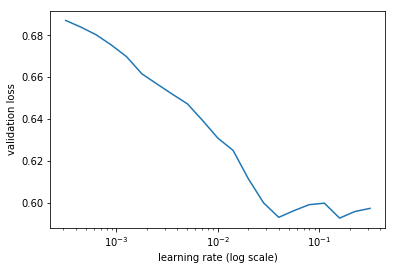

In [28]:
learn.lr_find()
learn.sched.plot()

In [29]:
lr=1e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [30]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.320732   0.318519   0.898345   0.781979  
    1      0.239926   0.181447   0.933973   0.862999                                                                   
    2      0.195142   0.153037   0.938912   0.875766                                                                   
    3      0.170332   0.139851   0.942324   0.885264                                                                   


[array([0.13985]), 0.9423238360692584, 0.8852639530322675]

In [40]:
pred = learn.predict(is_test=True)

In [41]:
pred = np.exp(pred)

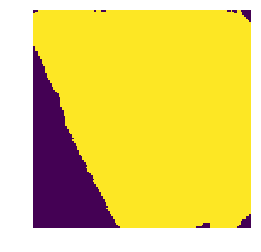

In [42]:
show_img(pred[125]>1);

In [43]:
pred.shape

(18000, 128, 128)

In [44]:
from skimage.transform import resize
#x = resize(pred, (128, 128, 1), mode='constant', preserve_range=True)

preds_test_upsampled = []
for i in tnrange(len(pred)):
    preds_test_upsampled.append(resize(np.squeeze(pred[i]), 
                                       (101, 101), 
                                       mode='constant', preserve_range=True))

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\Users\tsnar\AppData\Local\conda\conda\envs\fastai\lib\site-packages\skimage\transform\_warps.py:110:

In [45]:
preds_test_upsampled[0].shape

(101, 101)

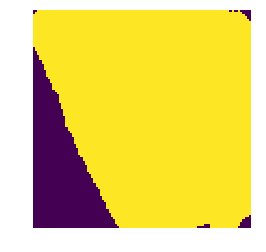

In [46]:
show_img(preds_test_upsampled[125]>1);

In [47]:
test_ids = test_csv['id']
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [48]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_V7.csv')

In [46]:
len(sub)

18000

In [47]:
learn.save('tmp')

In [32]:
learn.load('tmp')

In [33]:
learn.unfreeze()
learn.bn_freeze(True)

In [34]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.137165   0.139157   0.941418   0.881734  
    1      0.138808   0.141088   0.947058   0.890125                                                                   
    2      0.126742   0.135724   0.943878   0.889006                                                                   
    3      0.120849   0.130167   0.947689   0.894851                                                                   


[array([0.13017]), 0.9476893582041301, 0.8948512474580608]

In [35]:
learn.save('128')

In [36]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

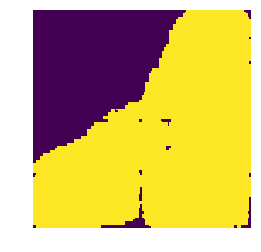

In [41]:
show_img(py[10]>1);

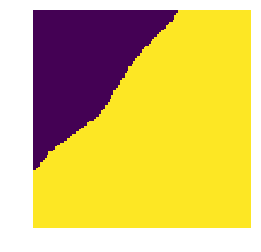

In [40]:
show_img(y[10]);

## U-net (ish)

In [29]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [30]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [31]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [32]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [33]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
#m = (Unet34(m_base))
models = UnetModel(m)

In [67]:
# Wrap everything nicely
# class UpsampleModel():
#     def __init__(self, model, cut_lr, name='upsample'):
#         self.model,self.name, self.cut_lr = model, name, cut_lr

#     def get_layer_groups(self, precompute):
#         lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
#         return lgs + [children(self.model)[1:]]

In [34]:
#cut, cut_lr = model_meta[f]
# def get_encoder(f, cut):
#     base_model = (cut_model(f(True), cut))
#     return nn.Sequential(*base_model)

In [35]:
#f = vgg16
#cut, cut_lr = model_meta[f]
#cut, cut_lr

In [36]:
#encoder = get_encoder(f, 30).cpu()

In [37]:
#from fastai.models.unet import *
#m = (DynamicUnet(encoder)).cpu()
#models = UpsampleModel(m,lr_cut)

In [34]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [35]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [36]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [37]:
learn.freeze_to(1)

 92%|█████████████████████████████████████████████████████████████████▋     | 37/40 [00:19<00:01,  1.94it/s, loss=2.18]

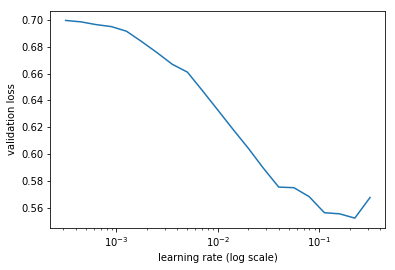

In [42]:
learn.lr_find()
learn.sched.plot()

In [38]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [44]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.342272   0.95146    0.890403   0.754283  
    1      0.238583   0.171382   0.937458   0.872653                                                                   
    2      0.195008   0.172871   0.933842   0.867226                                                                   
    3      0.171062   0.145894   0.943863   0.887704                                                                   
    4      0.155701   0.166426   0.925363   0.852301                                                                   
    5      0.143981   0.140804   0.945088   0.886998                                                                   
    6      0.132371   0.129164   0.950135   0.900163                                                                   
    7      0.119811   0.145589   0.942829   0.881681                                                     

[array([0.14559]), 0.9428290605545044, 0.8816810769341437]

In [44]:
learn.save('128urn-tmp')

In [45]:
learn.load('128urn-tmp')

In [39]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs/4, 5, wds=wd, cycle_len=30,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.484217   0.394225   0.712555   0.0       
    1      0.314575   0.285181   0.852734   0.727737                                                                   
    2      0.247704   0.288769   0.885632   0.802795                                                                   
    3      0.208301   0.335397   0.869611   0.746653                                                                   
    4      0.182126   0.230526   0.885034   0.798562                                                                   
    5      0.168979   0.228485   0.898755   0.843314                                                                   
    6      0.15625    0.24794    0.874762   0.767197                                                                   
    7      0.150682   0.233882   0.869562   0.768196                                                     

In [58]:
learn.save('128urn-0')

In [59]:
learn.load('128urn-0')

In [60]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

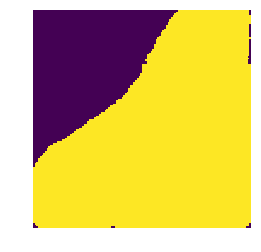

In [62]:
show_img(py[10]>0);

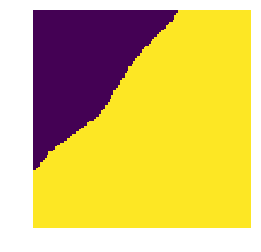

In [63]:
show_img(y[10]);

In [64]:
m.close()

## 512x512

In [119]:
sz=256
bs=16

In [38]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test = (x_test, y_test), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [39]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [40]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [41]:
learn.freeze_to(1)

In [42]:
learn.load('128urn-0')

In [125]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.214359   0.253632   0.921405   0.792828  
    1      0.205906   0.193587   0.914812   0.803155                                                                   
    2      0.187104   0.150496   0.940159   0.873306                                                                   
    3      0.163573   0.142117   0.943701   0.878078                                                                   
    4      0.159932   0.128871   0.947181   0.883284                                                                   



[array([0.12887]), 0.9471807177104647, 0.8832843038506228]

In [126]:
learn.save('512urn-tmp')

In [43]:
learn.unfreeze()
learn.bn_freeze(True)

In [44]:
learn.load('512urn-tmp')

In [47]:
learn.fit(lrs/4,1,wds=wd, cycle_len=10,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.160115   0.134117   0.944678   0.887634  
    1      0.132963   0.130248   0.947267   0.893296                                                                   
    2      0.12302    0.124668   0.95184    0.901098                                                                   
    3      0.112696   0.120815   0.951183   0.900379                                                                   
    4      0.106256   0.123403   0.950345   0.900638                                                                   
    5      0.101799   0.124937   0.950843   0.896788                                                                   
    6      0.096367   0.11897    0.952379   0.902811                                                                   
    7      0.093538   0.120929   0.953101   0.903991                                                     

[array([0.1217]), 0.9519308796004643, 0.9018179055560793]

In [74]:
learn.save('512urn')

In [26]:
learn.load('512urn')

In [75]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

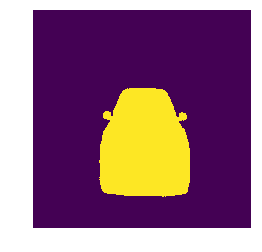

In [76]:
show_img(py[0]>0);

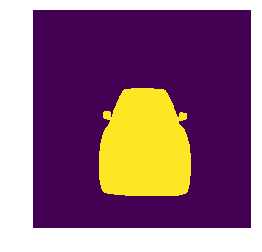

In [77]:
show_img(y[0]);

In [78]:
m.close()

## 1024x1024

In [26]:
sz=1024
bs=4

In [27]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [28]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [29]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [30]:
learn.load('512urn')

In [31]:
learn.freeze_to(1)

In [32]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.007656   0.008155   0.997247   0.99353   
    1      0.004706   0.00509    0.998039   0.995437             



[0.005090427414942828, 0.9980387706605215, 0.995437301104031]

In [33]:
learn.save('1024urn-tmp')

In [30]:
learn.load('1024urn-tmp')

In [31]:
learn.unfreeze()
learn.bn_freeze(True)

In [32]:
lrs = np.array([lr/200,lr/30,lr])

In [33]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.005688   0.006135   0.997616   0.994616  
    1      0.004412   0.005223   0.997983   0.995349             
    2      0.004186   0.004975   0.99806    0.99554              
    3      0.004016   0.004899   0.99812    0.995627             



[0.004898778487196458, 0.9981196409180051, 0.9956271404784823]

In [33]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004169   0.004962   0.998049   0.995517  
    1      0.004022   0.004595   0.99823    0.995818             
    2      0.003772   0.004497   0.998215   0.995916             
    3      0.003618   0.004435   0.998291   0.995991             



[0.004434524739663753, 0.9982911745707194, 0.9959913929776539]

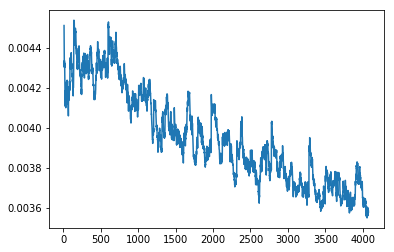

In [34]:
learn.sched.plot_loss()

In [35]:
learn.save('1024urn')

In [26]:
learn.load('1024urn')

In [36]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

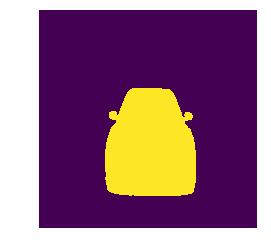

In [37]:
show_img(py[0]>0);

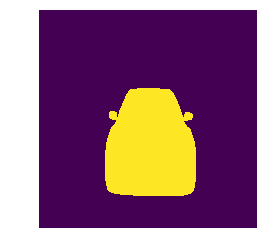

In [38]:
show_img(y[0]);